# Reconstructing Surface Ocean pCO$_2$ with LightGBM, Categorical Features, and Mapped Accuracy

Applied Data Science: Climate Prediction Challenges 

Spring 2022 

Group 5 Members: 
- Kate Marsh 
- Nan Zheng 
- Ziwen Ye
- Gabriel Weinstein

#**Introduction** 

Our motivation was the in-class discussion about the lack of accuracy in some regions of the globe. We were interested in creating a model that showed the accuracy in each region, as well as improving the model accuracy from the XGBoost standard algorithm. 

In our project we implemented a LightGBM model with and without categorical variables in order to improve air-sea CO2 exchange modeling. LightGBM models are often able to train faster than XGBoost and require less memory to run. RAM was a consistent limiting factor in this project, and we made efforts to work around it. We used Collab pro in order to have more available ram and ran model tests seperately in order to save RAM. 

In the end, we chose to represent accuracy with a quantile loss function on the LightGBM model with categorical features. We chose latitude (defined in 10 degree bands) and season as categorical features to improve model performace. Using light GBM with categorical features, we were able to reduce the MSE by 1/3 on the unseen data, reduce test speed, reduce bias, and increase r2 and correlation values compared to the original XGBoost model. 

## Part I: Install python packages and set up workplace


In [1]:
#@title Install the packages
!pip install SkillMetrics
!pip install cmocean
!pip3 install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 149 kB 60.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 223 kB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 14.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 33.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 22.8 MB/s 
  Installing build dependenci

In [2]:
#@title Import necessary packages
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import skill_metrics as sm
import time

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
import lightgbm as lgbm

# machine learning libraries
from sklearn.model_selection import train_test_split

In [3]:
#@title Connect colab and Set work directory
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/" # change it to your own project dir
os.chdir(f"{root_dir}/lib/") 
print(os.getcwd())
#/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib


In [4]:
# @title Load user python codes
# Python file with supporting functions
# pre.py and spatial_map.py must be in your working directory
import pre 
#import decompose as stl
from spatial_map import SpatialMap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part II: Reconstruction

In [5]:
# @title Define the ESM member
# define which ESM you will use, which member of the large ensemble, time range, and directories of the files
ens = 'CanESM2'
member = 'r1r10'

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

data_output_dir = f"{root_dir}/ESM/data/processed"
ensemble_dir_head = f"{root_dir}/ESM/" # Set this to where you have placed the raw data
xco2_path = f"{root_dir}/ESM/CESM001/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc" # xCO2(atmospheric CO2 mole fraction) is the same across members so only reference it once


reference_output_dir = f"{root_dir}/references"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

'''
approach = "xg"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
'''

'\napproach = "xg"\napproach_output_dir = f"{other_output_dir}/{approach}"\nparam_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"\n'

In [6]:
# @title Load the ESM member
# load and save data
df = pre.create_inputs(ensemble_dir_head, ens, member, dates, xco2_path=xco2_path)
pre.save_clean_data(df, data_output_dir, ens, member)

# the data preprocess take 60 s

start to import member data
finish importing member data
start to create feature


/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/pre.py:130: RuntimeWarning: Mean of empty slice
  avg_val = np.nanmean(array_2d[(i*N_batch):((i+1)*N_batch),:])


Starting data saving process
Save complete


In [7]:
# @title Define the model
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

## Part III: Create and evaluate reconstruction

# **Methodology**

### III.1 Prepare seen and unseen data.


"Seen" data are sampled from the ESM output at the locations where data exist in the real world. The database of pCO$_2$ data is the Surface Ocean CO$_2$ Atlas (SOCAT, https://www.socat.info).  

"Unseen" data are all the points that the reconstruction cannot learn from (in training, evaluation, or test). We are only able to compare to the unseen data within our ESM testbed. This capability is the fundamental motivation for the testbed.  

Our ultimate goal is to understand the uncertainties in a real world pCO$_2$ reconstruction. The testbed allows us to understand the strengths and weaknesses of any reconstruction approach. The strongest reconstruction approaches can then be used to reconstruct surface ocean pCO$_2$ for the real world using the actual SOCAT data (e.g. Bennington et al. 2022, in review for JAMES).

In [ ]:
#@title Categorical Features (Latitude Category, Longitude, Hemisphere, Season)
import gc 
df_new_all = df.reset_index(drop=False) 
del df; gc.collect()

#df_new_all = pd.read_csv("./DF_Reset_Index.csv", iterator = True, chunksize = 3000)
#df_new_all = pd.concat(df_new_all, ignore_index=True)


# df_new_all['lat_cat'] = df_new_all['ylat']
# df_new_all['lon_cat'] = df_new_all['xlon']

# lat_bin = [i for i in range(-90, 91, 1)]
# lat_name = [f"[{i}]-[{i+1}]" for i in range(-90, 90, 1)]
# df_new_all['lat_cat'] = pd.cut(df_new_all['ylat'],
#                                bins = lat_bin,
#                                labels = lat_name)
df_new_all['lat_cat'] = pd.cut(df_new_all['ylat'], 
                    bins=[-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], 
                    labels=['neg90to80', 'new80to70',  'neg70to60',  'neg60to50',  'neg50to40',
                            'neg40to30', 'neg30to20',  'neg20to10',  'neg10to0',  '0to10',
                            '10to20', '20to30', '30to40', '40to50', '50to60', '60to70',
                            '70to80','80to90'])

# cut by 10 degrees - Latitude was divided into 10 degree slices in order to not use too much ram while also including small enough slices to include latitudinal variation.
# too many categories may also create issues with processing and cause problems in the algorithm. 

# lon_bin = [i for i in range(-90, 91, 1)]
# lon_name = [f"[{i}]-[{i+1}]" for i in range(-90, 90, 1)]
# df_new_all['lon_cat'] = pd.cut(df_new_all['xlon'], lon_bin, lon_name)

#df_new_all['lon_cat'] = pd.cut(df_new_all['xlon'], 
#                    bins=[-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], 
#                    labels=['-90to-80', '-80to-70',  '-70to-60',  '-60to-50',  '-50to-40',
#                            '-40to-30', '-30to-20',  '-20to-10',  '-10to0',  '0to10',
#                            '10to20', '20to30', '30to40', '40to50', '50to60', '60to70',
#                            '70to80','80to90'])


df_new_all['hemisphere'] = pd.cut(df_new_all['ylat'], 
                    bins=[-90, 0, 90], 
                    labels=['south','north'])


df_new_all['date_offset'] = (df_new_all.time.dt.month*100 + df_new_all.time.dt.day - 320)%1300

# as if all northern hemisphere
df_new_all['season'] = pd.cut(df_new_all['date_offset'], [0, 300, 602, 900, 1300], 
                       labels=['spring', 'summer', 'fall', 'winter'])
#def convert_hemi(x):
#    if (x == 'spring'):
#      x = 'fall'
#    elif (x == 'summer'):
#      x = 'winter'
#    elif (x == 'fall'):
#      x = 'spring'
#    elif (x == 'winter'):
#      x = 'summer'
#    return x

#if (df_new_all['hemisphere'] == 'south'):
#    df_new_all['season_new'] = df_new_all['season'].apply(
#        lambda x: convert_hemi(x))
#df_new_all['season'] = np.where(df_new_all['hemisphere'] == "south", 
#                                ['spring', 'summer', 'fall', 'winter'], 
#                                ['fall', 'winter', 'spring', 'summer'])

cat_features = ['lat_cat', "season"]
# , "lon_cat"
from sklearn.preprocessing import LabelEncoder
lb_list = []
for c in cat_features:
    lb = LabelEncoder()
    df_new_all[c] = lb.fit_transform(df_new_all[c])
    lb_list.append((c, lb))

Here we define and implement our categorical variables of latitude, longitude, hemisphere, and season. Latitude was defined as 10 degree slices of Earth's surface from -90 to 90N. Hemisphere and latitude, although both defined by ranges in latitude, were tested in order to separate out large scale hemipsheric features from smaller, more local, latitudinal influences on CO2 exchange. Seasons were defined as 3 month periods such that December, January, and February (DJF) define winter.

Later, we decide to use only the season and latitude categorical features. 

In [ ]:
# @title Categorical Data preparation 
# prepare the seen and unseen data. split the trian and test data
features_sel_cat = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 
                    'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 
                    'A', 'B', 'C', 'T0', 'T1', 'season', 'lat_cat']
# Not including: "hemisphere", 'lon cat'


# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df_new_all[features_sel_cat+target_sel+['net_mask']].isna().any(axis=1)) & (df_new_all[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df_new_all['socat_mask'] == 1))
unseen_sel = (recon_sel & (df_new_all['socat_mask'] == 0))
        
# Convert dataframe to numpy arrays, train/val/test split
X = df_new_all.loc[sel,features_sel]
X2 = df_new_all.loc[sel,features_sel_cat]
y = df_new_all.loc[sel,target_sel]

#List of categorical columns
categoricalcolumns = X2.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X2.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)

X = X.to_numpy()
X2 = X2.to_numpy()
y = y.to_numpy().ravel()              

#non-categorical 
N = X.shape[0]
train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop)
X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 
    
#categorical

N = X2.shape[0]
train_val_idx2, train_idx2, val_idx2, test_idx2 = pre.train_val_test_split(N, test_prop, val_prop)
X2_train_val, X2_train, X2_val, X2_test, y2_train_val, y2_train, y2_val, y2_test = pre.apply_splits(X2, y, train_val_idx2, train_idx2, val_idx2, test_idx2) 
    
# Define the model based on which approach to use    
# if first_mem:
#   model = XGBRegressor(n_jobs=jobs)
#   param_grid = xg_param_grid
#   grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=False)
#   grid.fit(X_train_val, y_train_val)
#   best_params[ens] = grid.best_params_
#   first_mem = False


### III.2 Train / validate reconstruction model

#### III.2.1 Algorithm selection 

XGBoost v.s. LightGBM(with or without Categorical)

Here we test the XGBoost model alongside the LightGBM model with and without categorical features. Although there is some variability across different runs, categorical features tend to improve the model performance as we will see later in the notebook. The choice of which categorical features to implement also  impacts the model performance. After running a few different times, we chose to include a season feature and a latitude category feature. The other options (longitude category and hemisphere) hindered model performance. 

In [ ]:
#@title XGBoost
t0 = time.time()
model_xg = XGBRegressor(n_jobs=1, feature_names = features_sel)
model_xg.fit(X_train_val, y_train_val) 

test_performance_xg = defaultdict(dict)
y_pred_test_xg = model_xg.predict(X_test)
test_performance_xg[ens][member] = pre.evaluate_test(y_test, y_pred_test_xg)
t1_xg = time.time()-t0

# Redo this analysis on the unseen data
t0 = time.time()
unseen_performance_xg = defaultdict(dict)
y_pred_unseen_xg = model_xg.predict(df_new_all.loc[unseen_sel,features_sel].to_numpy())
y_unseen_xg = df_new_all.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance_xg[ens][member] = pre.evaluate_test(y_unseen_xg, y_pred_unseen_xg)
t2_xg = time.time()-t0

print("The time consumed by XGBoost: ", t1_xg+t2_xg)
print(test_performance_xg)
print(unseen_performance_xg)

In [ ]:
#@title LightGBM
t0 = time.time()
model_lg = LGBMRegressor(n_jobs=1, feature_name = features_sel)
model_lg.fit(X_train_val, y_train_val) 

test_performance_lg = defaultdict(dict)
y_pred_test_lg = model_lg.predict(X_test)
test_performance_lg[ens][member] = pre.evaluate_test(y_test, y_pred_test_lg)
t1_lg = time.time()-t0

# Redo this analysis on the unseen data
t0 = time.time()
unseen_performance_lg = defaultdict(dict)
y_pred_unseen_lg = model_lg.predict(df_new_all.loc[unseen_sel,features_sel].to_numpy())
y_unseen_lg = df_new_all.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance_lg[ens][member] = pre.evaluate_test(y_unseen_lg, y_pred_unseen_lg)
t2_lg = time.time()-t0

print("The time consumed by LightGBM: ", t1_lg+t2_lg)
print(test_performance_lg)
print(unseen_performance_lg)

The time consumed by LightGBM:  56.320353984832764
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 151.00934217400095, 'mae': 8.394457656715478, 'medae': 6.3197120834059035, 'max_error': 292.77165719390473, 'bias': 0.08423929510979633, 'r2': 0.9001304081367796, 'corr': 0.9495617349501517, 'cent_rmse': 12.288297069496139, 'stdev': 35.401785286507284, 'amp_ratio': 0.8363679624608347, 'stdev_ref': 38.88528, 'range_ref': 559.10455, 'iqr_ref': 50.73138427734375}}})
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 376.60563967132725, 'mae': 11.256229355742256, 'medae': 7.9614038876468385, 'max_error': 527.084872239287, 'bias': 1.139344528384754, 'r2': 0.7506461792138683, 'corr': 0.8680367413362652, 'cent_rmse': 19.37284837110895, 'stdev': 32.00430542060959, 'amp_ratio': 0.7231069203783149, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}}})


In [ ]:
#@title LightGBM with Categorical 
t0 = time.time()
model_c = LGBMRegressor(n_jobs=1, categorical_feature = cat_features, 
                        feature_name = features_sel_cat)
model_c.fit(X2_train_val, y2_train_val) 

test_performance_c = defaultdict(dict)
y_pred_test_c = model_c.predict(X2_test)
test_performance_c[ens][member] = pre.evaluate_test(y2_test, y_pred_test_c)
t1_c = time.time()-t0

# Redo this analysis on the unseen data
t0 = time.time()
unseen_performance_c = defaultdict(dict)
y_pred_unseen_c= model_c.predict(df_new_all.loc[unseen_sel,features_sel_cat].to_numpy())
y_unseen_c = df_new_all.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance_c[ens][member] = pre.evaluate_test(y_unseen_c, y_pred_unseen_c)
t2_c = time.time()-t0

print("The time consumed by LightGBM w Categorical Features: ", t1_c+t2_c)
print(test_performance_c)
print(unseen_performance_c)

The time consumed by LightGBM w Categorical Features:  56.20957541465759
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 153.4576822030286, 'mae': 8.313632935873503, 'medae': 6.181957909033713, 'max_error': 273.306041352911, 'bias': -0.0758190912051191, 'r2': 0.9009093731869182, 'corr': 0.9501738298539253, 'cent_rmse': 12.387571638301603, 'stdev': 35.66909249410003, 'amp_ratio': 0.7440364011591345, 'stdev_ref': 39.35302, 'range_ref': 631.10266, 'iqr_ref': 51.05034637451172}}})
defaultdict(<class 'dict'>, {'CanESM2': {'r1r10': {'mse': 381.5999919790575, 'mae': 11.269064786204424, 'medae': 7.9794551387939805, 'max_error': 513.3806302985301, 'bias': 0.9955088202606817, 'r2': 0.7473393757592747, 'corr': 0.8661219105877475, 'cent_rmse': 19.509195518323786, 'stdev': 31.849057174740715, 'amp_ratio': 0.7282114647625787, 'stdev_ref': 38.86292, 'range_ref': 694.08203, 'iqr_ref': 47.25750732421875}}})


# **Results**

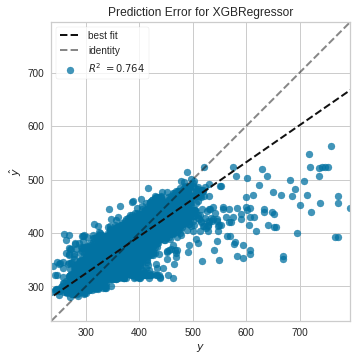

In [ ]:
#@title Prediction Error Graph for XGBoost Regression
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(model_xg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
visualizer.finalize(title = "Prediction Error for LGBM (w/o Categorical)")

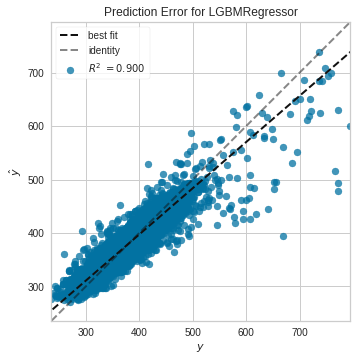

In [ ]:
#@title Prediction Error Graph for LGBM Regression (No Categories)
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(model_lg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
visualizer.finalize(title = "Prediction Error for LGBM (w/o Categorical)")

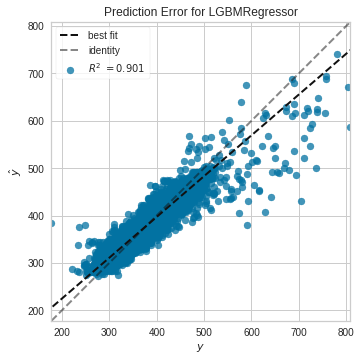

In [ ]:
#@title Prediction Error Graph for LGBM Regression (With Categories)
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(model_c)

visualizer.fit(X2_train, y2_train)  # Fit the training data to the visualizer
visualizer.score(X2_test, y2_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
visualizer.finalize(title = "Prediction Error for LGBM w Categorical")

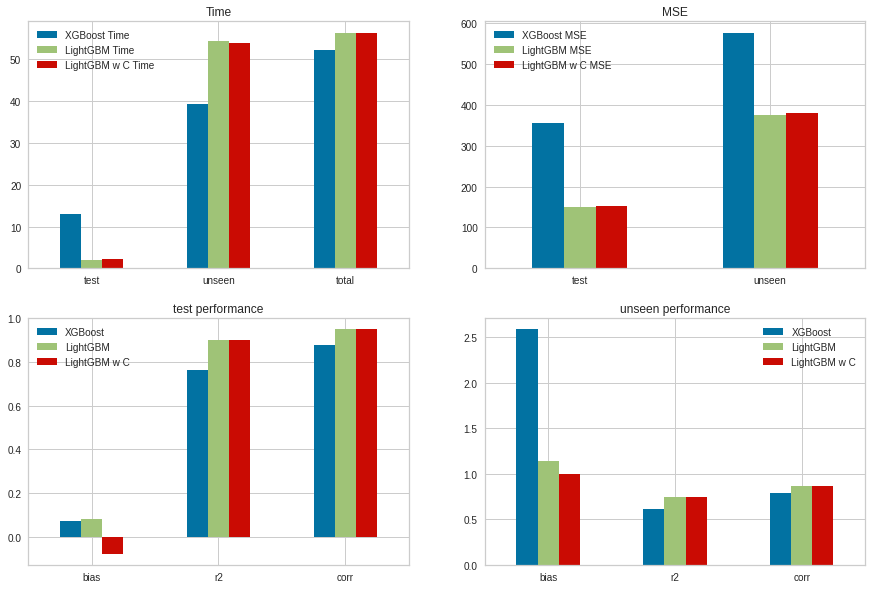

In [ ]:
#@title Visualization
test_perf_xg = test_performance_xg['CanESM2']['r1r10']
test_perf_lg = test_performance_lg['CanESM2']['r1r10']
test_perf_c = test_performance_c['CanESM2']['r1r10']
unseen_perf_xg = unseen_performance_xg['CanESM2']['r1r10']
unseen_perf_lg = unseen_performance_lg['CanESM2']['r1r10']
unseen_perf_c = unseen_performance_c['CanESM2']['r1r10']

df1 = pd.DataFrame({
    "XGBoost Time":[t1_xg,t2_xg,t1_xg+t2_xg],
    "LightGBM Time":[t1_lg,t2_lg,t1_lg+t2_lg],
    "LightGBM w C Time":[t1_c,t2_c,t1_c+t2_c]},
    index=["test", "unseen", "total"])
df2 = pd.DataFrame({
    "XGBoost MSE":[test_perf_xg['mse'],unseen_perf_xg['mse']],
    "LightGBM MSE":[test_perf_lg['mse'],unseen_perf_lg['mse']],
    "LightGBM w C MSE":[test_perf_c['mse'],unseen_perf_c['mse']]},
    index=["test", "unseen"])
df3 = pd.DataFrame({
    "XGBoost":[test_perf_xg['bias'],test_perf_xg['r2'],test_perf_xg['corr']],
    "LightGBM":[test_perf_lg['bias'],test_perf_lg['r2'],test_perf_lg['corr']],
    "LightGBM w C":[test_perf_c['bias'],test_perf_c['r2'],test_perf_c['corr']]},
    index=["bias", "r2", "corr"])
df4 = pd.DataFrame({
    "XGBoost":[unseen_perf_xg['bias'],unseen_perf_xg['r2'],unseen_perf_xg['corr']],
    "LightGBM":[unseen_perf_lg['bias'],unseen_perf_lg['r2'],unseen_perf_lg['corr']],
    "LightGBM w C":[unseen_perf_c['bias'],unseen_perf_c['r2'],unseen_perf_c['corr']]},
    index=["bias", "r2", "corr"])
df_list = [df1 ,df2, df3, df4]
title_list = ["Time", "MSE", "test performance", "unseen performance"]
fig, axes = plt.subplots(2, 2, figsize=(15,10))

count=0
for r in range(2):
  for c in range(2):
    df_list[count].plot(ax=axes[r,c], kind="bar", title=title_list[count], rot = 0)
    count+=1

Here we visualize some metrics of evaluating our models. We see that LightGBM performs pretraining much faster than XGBoost. However, the total time taken by LightGBM (both with categorical features and without) is only slightly less than that of XGBoost. Adding categorical features to  LightGBM only slightly increases the amount of time necessary to run the model. 

We also see that LightGBM (with and without categorical features) yields lower mean squared errors than XGBoost. The categorical features do not substantially improve error in the model. Despite not substantially improving the model, the LightGBM with categorical features consistenly performs best on the unseen dataset with the highest r2 and correlation, while having the lowest bias. In addition, it consistently has the lowest MSE on unseen data. 

Initially, we also created a catboost model, but we found for comparison purposes and for our later accuracy model, using LightGBM with categories was ideal. 

For these reasons, we use LightGBM with Categorical variables (season and latitude categories) to perform quantile loss. 



#### III.2.2 Models with quantiles

Here we perform a quantile regression with q=0.1 and q=0.9, which gives a prediction interval of [y_0.1, y_0.9]. This tells us that there is an 80% chance that the y values fall between the two regression functions. Quantiles can be thought of as conditional medians where when q=0.1 90% of real y is greater than this regression. See Quantile Regression in https://www.yuritan.nl/posts/prediction_uncertainty/. 

In [ ]:
#@title Models with quantiles
y_pred_set = []
error_set = []
quantile = [0.1, 0.9]

y_pred_set2 = []
error_set2 = []

# lower
model_l = LGBMRegressor(objective = 'quantile', metric = 'quantile', alpha = 0.1, categorical_feature = cat_features)
model_l.fit(X2_train_val, y2_train_val)          
y_pred_test = model_l.predict(X2_test)
y_pred_set.append(y_pred_test)
#error_set.append(abs(y_pred_test-y_test))

# upper
model_u = LGBMRegressor(objective = 'quantile', metric = 'quantile', alpha = 0.9, categorical_feature = cat_features)
model_u.fit(X2_train_val, y2_train_val)          
y_pred_test = model_u.predict(X2_test)
y_pred_set.append(y_pred_test)
#error_set.append(abs(y_pred_test-y_test))

# Without Categorical Features 

# lower
model_l2 = LGBMRegressor(objective = 'quantile', metric = 'quantile', alpha = 0.1)
model_l2.fit(X_train_val, y_train_val)          
y_pred_test2 = model_l2.predict(X_test)
y_pred_set2.append(y_pred_test2)
#error_set.append(abs(y_pred_test-y_test))

# upper
model_u2 = LGBMRegressor(objective = 'quantile', metric = 'quantile', alpha = 0.9)
model_u2.fit(X_train_val, y_train_val)          
y_pred_test2 = model_u2.predict(X_test)
y_pred_set2.append(y_pred_test2)
#error_set.append(abs(y_pred_test-y_test))

In [ ]:
# @title Total accuracy
u = y2_test <= y_pred_set[1]
l = y2_test >= y_pred_set[0]
acc_num = 0
for i in range(len(y2_test)):
  if u[i] and l[i]:
    acc_num += 1
accuracy = acc_num/len(y2_test)
print("The prediction interval (With Categories) contains %2d percent of real y" % round(accuracy*100))

# No Categories accuracy 
u2 = y_test <= y_pred_set2[1]
l2 = y_test >= y_pred_set2[0]
acc_num2 = 0
for i in range(len(y_test)):
  if u2[i] and l2[i]:
    acc_num2 += 1
accuracy_no_cat = acc_num2/len(y_test)
print("The prediction interval (Without Categories) contains %2d percent of real y" % round(accuracy_no_cat*100))

The prediction interval (With Categories) contains 80 percent of real y
The prediction interval (Without Categories) contains 80 percent of real y


Given that quantiles of q=0.1 and q=0.9 were chosen, it makes sense that the prediction intervals contain 80% of real y. This shows that the quantiles are working properly in the model and that the effectively form bounds of the most likely values of real y. 

We conducted the total accuracy measurement on both the categorical model and non-categorical model to compare their performance; however, they both perform the same. 

In [ ]:
#@title Save models/data

#Categorical models
approach = "cat_quant_l"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
pre.save_model(model_l, model_output_dir, approach, ens, member)

approach = "cat_quant_u"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
pre.save_model(model_u, model_output_dir, approach, ens, member)

y_pred_unseen_l = model_l.predict(df_new_all.loc[unseen_sel,features_sel_cat].to_numpy()) #lower 
y_pred_unseen_u = model_u.predict(df_new_all.loc[unseen_sel,features_sel_cat].to_numpy()) #upper
y_pred_seen_l = model_l.predict(X2) # lower
y_pred_seen_u = model_u.predict(X2) # upper
df_new_all['pCO2_recon_l'] = np.nan
df_new_all['pCO2_recon_u'] = np.nan
df_new_all.loc[unseen_sel,['pCO2_recon_l']] = y_pred_unseen_l
df_new_all.loc[unseen_sel,['pCO2_recon_u']] = y_pred_unseen_u
df_new_all.loc[sel,['pCO2_recon_l']] = y_pred_seen_l
df_new_all.loc[sel,['pCO2_recon_u']] = y_pred_seen_u
df_new_all.set_index(['time', 'xlon', 'ylat'], inplace = True)
df_new_all['marker'] = np.where((df_new_all.pCO2 >= df_new_all.pCO2_recon_l) & (df_new_all.pCO2 <= df_new_all.pCO2_recon_u), 1, 0)
df_new_all['marker'] = np.where(df_new_all.pCO2_recon_l.isnull(), np.nan, df_new_all['marker'])
DS_recon = df_new_all[['net_mask','socat_mask','pCO2', 'pCO2_recon_u', 'pCO2_recon_l', 'marker']].to_xarray()

approach = "cat_quant"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
pre.save_recon(DS_recon, recon_output_dir, approach, ens, member)

'''
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]
                                  for i in test_performance.keys()
                                  for j in test_performance[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]
                                  for i in unseen_performance.keys()
                                  for j in unseen_performance[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)
'''

Starting model saving process
Save complete
Starting model saving process
Save complete
Starting reconstruction saving process
Save complete


'\n# Convert performance metrics to dataframes\ntest_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]\n                                  for i in test_performance.keys()\n                                  for j in test_performance[i].keys()},\n                                 orient=\'index\')\n\nunseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]\n                                  for i in unseen_performance.keys()\n                                  for j in unseen_performance[i].keys()},\n                                 orient=\'index\')\n\ntest_df.index.names = ["model","member"]\nunseen_df.index.names = ["model","member"]\n\n# Save the dataframes too\ntest_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"\nunseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"\n\ntest_df.to_pickle(test_df_fname)\nunseen_df.to_pickle(unseen_df_fname)\n'

In [ ]:
#@title Release memory
del X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test
del X2_train_val, X2_train, X2_val, X2_test, y2_train_val, y2_train, y2_val, y2_test
del y_pred_test, DS_recon, test_performance_c, unseen_performance_c, y_pred_test_c
del test_performance_xg, test_performance_lg, unseen_performance_xg, unseen_performance_lg
del y_pred_set, error_set, y_pred_unseen_l, y_pred_seen_l, y_pred_unseen_u, y_pred_seen_u
del y_pred_test_lg, y_pred_test_xg, y_pred_unseen_lg, y_pred_unseen_xg, y_pred_unseen_c
#pre.apply_detrend('xg', ens, member)

### III.3 Map of accuracy

After determining the accuracy of our model we then plot the accuracies of each prediction onto a global map of Earth. This allows us to see where our model struggles to accurately predict CO2 exchange between the atmosphere and ocean. Overall, we see that the model is mostly accurate with a few problem areas. The model generally performs more poorly in coastal regions. The eastern equatorial Pacific (off the west coast of South America) shows low accuracy values, and may relate to oceanographic processes (upwelling) that prevent the model from obtaining accurate results. It is possible that with the addition of a categorical feature that includes circulation and ventilation patterns that the accuracy of our model would improve.

accuracy data by ML approach


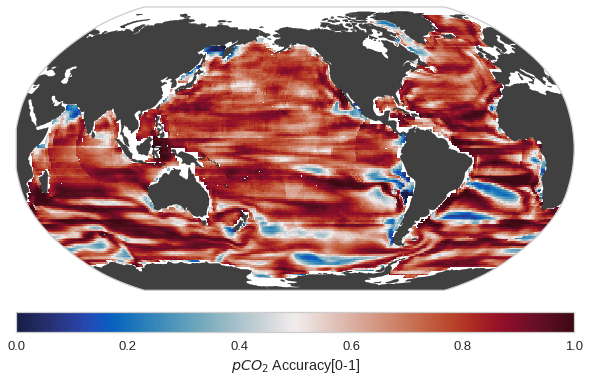

In [ ]:
# @title Accuracy map
# data_sel = "raw"
import warnings
warnings.filterwarnings("ignore")

approach = "cat_quant"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"        
recon_fname_out = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon = xr.load_dataset(recon_fname_out)
map_data = defaultdict(float) # Data by ML approach
map_data[(approach,"accuracy")] = DS_recon['marker'].mean(axis = 0)
metric_sel = "accuracy"
vrange = [0, 1, 0.05]
fig_shape = (1,1)
cmap = cm.cm.balance
lab = '$pCO_2$ Accuracy[0-1]'

print(f"{metric_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(10,6))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);
plt.show()

#**Conclusion**
In this project we determined the effectiveness of using a LGBM, with and without categorical features, to model pCO2 transfering between the ocean and atmosphere. We found that the LGBM improves model accuracy but took slightly more time overall. It is also important to note that the results change somewhat between runs. Unfortunately, the categorical features we chose only slightly improved on the model. This was not true when longitude and hemisphere were included as categorical features. This is likely due to longitude not having an intuitive effect on CO2 exchange. Latitude and season both improved the model slightly. Once we had run the model with our categorical variables we used quantile regressions to determine our model's accuracy. We found that overall our model was accurate but there were certain regions in the ocean that our model failed to capture. This areas are primarily coastal but there are certain areas of low accuracy (such as the eastern equatorial Pacific) that may be explained by oceanographic processes. It would be useful to implement other promising features in future studies. 

## **Appendix**

In [ ]:
#@title Creating More Explanatory Maps
#Full reconstruction and temporal deconstruction metric maps
# it take 20 seconds

data_types = ["raw"]

map_data = defaultdict(float) # Data by ML approach
map_data_ens = defaultdict(float) # Data by ML approach and ensemble model

N_ens = 1
N_tot = 1

recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
            
recon_fname_out = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
            
DS_recon = xr.load_dataset(recon_fname_out)
                        
recon = {}
recon["raw"] = DS_recon["pCO2_recon_l"]
for i in data_types[1:]:
  recon[i] = DS_recon[f"pCO2_recon_{i}"]

ref = {}
ref["raw"] = DS_recon["pCO2"]
for i in data_types[1:]:
  ref[i] = DS_recon[f"pCO2_{i}"]
                
for i in data_types:
  xmean = ref[i].mean("time")
  ymean = recon[i].mean("time")
  x_minus_mean = ref[i] - xmean
  y_minus_mean = recon[i] - ymean
  ssx = xr.ufuncs.sqrt((x_minus_mean**2).sum("time"))
  ssy = xr.ufuncs.sqrt((y_minus_mean**2).sum("time"))
                
  corr = ( x_minus_mean * y_minus_mean ).sum("time") / (ssx*ssy)
  std_x = ref[i].std("time")
  std_y = recon[i].std("time")
  bias = (ymean - xmean)
                
                # Average bias
  map_data[(approach,i,"bias_mean")] += bias / N_tot
  map_data_ens[(ens,approach,i,"bias_mean")] += bias / N_ens
                
                # Average bias**2
  map_data[(approach,i,"bias_sq")] += bias**2 / N_tot
  map_data_ens[(ens,approach,i,"bias_sq")] += bias**2 / N_ens
                
                # Max bias
  map_data[(approach,i,"bias_max")] = np.maximum(map_data[(approach,i,"bias_max")], bias)
  map_data_ens[(ens,approach,i,"bias_max")] = np.maximum(map_data_ens[(ens,approach,i,"bias_max")], bias)
                
                # Min bias
  map_data[(approach,i,"bias_min")] = np.minimum(map_data[(approach,i,"bias_min")], bias)
  map_data_ens[(ens,approach,i,"bias_min")] = np.minimum(map_data_ens[(ens,approach,i,"bias_min")], bias)
                
                # Mean absolute error
  map_data[(approach,i,"mae")] += np.abs(bias) / N_tot
  map_data_ens[(ens,approach,i,"mae")] += np.abs(bias) / N_ens
                
                # Mean % bias
  map_data[(approach,i,"bias_%error")] += bias/xmean / N_tot
  map_data_ens[(ens,approach,i,"bias_%error")] += bias/xmean / N_ens
                
                # Mean absolute % bias
  map_data[(approach,i,"mae_%error")] += np.abs(bias)/xmean / N_tot
  map_data_ens[(ens,approach,i,"mae_%error")] += np.abs(bias)/xmean / N_ens
                
                # Mean correlation
  map_data[(approach,i,"corr_mean")] += corr / N_tot
  map_data_ens[(ens,approach,i,"corr_mean")] += corr / N_ens
                
                # Average corr**2
  map_data[(approach,i,"corr_sq")] += corr**2 / N_tot
  map_data_ens[(ens,approach,i,"corr_sq")] += corr**2 / N_ens

                # Stdev (amplitude) percentage error
  map_data[(approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_ens

                # Stdev (amplitude) absolute percentage error           
  map_data[(approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_ens


for i in data_types:
  map_data[(approach,i,"bias_std")] = np.sqrt(map_data[(approach,i,"bias_sq")] - map_data[(approach,i,"bias_mean")]**2)
  map_data[(approach,i,"corr_std")] = np.sqrt(map_data[(approach,i,"corr_sq")] - map_data[(approach,i,"corr_mean")]**2)

  map_data_ens[(ens,approach,i,"bias_std")] = np.sqrt(map_data_ens[(ens,approach,i,"bias_sq")] - map_data_ens[(ens,approach,i,"bias_mean")]**2)
  map_data_ens[(ens,approach,i,"corr_std")] = np.sqrt(map_data_ens[(ens,approach,i,"corr_sq")] - map_data_ens[(ens,approach,i,"corr_mean")]**2)


bias_min for raw data by ML approach


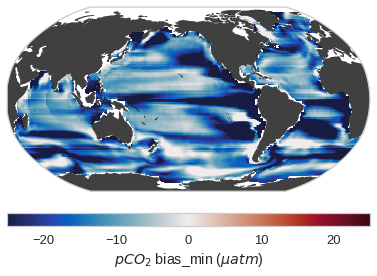

In [ ]:
#@title pCO2 Bias Min

data_sel = "raw"
metric_sel = "bias_min"
vrange = [-25, 25, 5]
fig_shape = (1,1)
cmap = cm.cm.balance
lab = '$pCO_2$ bias_min ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                      
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);

bias_max for raw data by ML approach


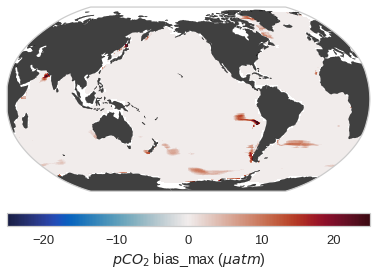

In [ ]:
#@title pCO2 Bias Max

data_sel = "raw"
metric_sel = "bias_max"
vrange = [-25, 25, 5]
fig_shape = (1,1)
cmap = cm.cm.balance
lab = '$pCO_2$ bias_max ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                      
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);

mae for raw data by ML approach


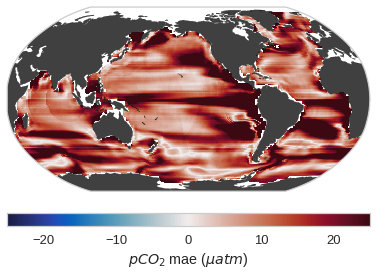

In [ ]:
#@title pCO2 Mean Absolute Error

data_sel = "raw"
metric_sel = "mae"
vrange = [-25, 25, 5]
fig_shape = (1,1)
cmap = cm.cm.balance
lab = '$pCO_2$ mae ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                      
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);

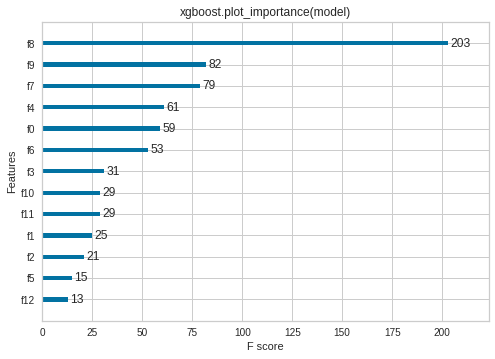

['chl_anom', 'xco2', 'A']
T1


In [ ]:
#@title Feature Importance in XGBoost
xgb.plot_importance(model_xg)
plt.title("xgboost.plot_importance(model)")
plt.show()
#column_names = df_new_all.columns.values.tolist()
print(features_sel[6:9])
# the three most imporant features for xgboost are mld_anom, MLD_clim, and mld_clim_log
print(features_sel[12])
# least important is sss_anom 

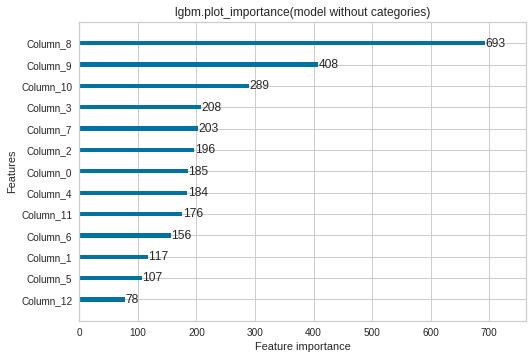

T1


In [ ]:
#@title Feature Importance in LGBM without Categories
lgbm.plot_importance(model_lg)
plt.title("lgbm.plot_importance(model without categories)")
plt.show()
# same for lbgm as xgboost, except C instead of A  
print(features_sel[12])

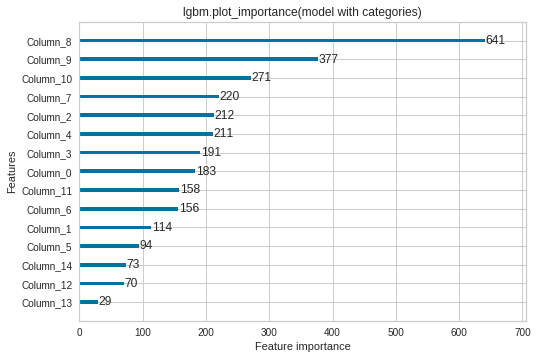

['xco2', 'A', 'B']
['T1', 'season', 'lat_cat']


In [ ]:
#@title Feature Importance in LGBM with Categories
lgbm.plot_importance(model_c)
plt.title("lgbm.plot_importance(model with categories)")
plt.show()
print(features_sel_cat[7:10])
# the three most imporant features for xgboost are mld_anom, MLD_clim, and mld_clim_log
print(features_sel_cat[12:15])
# while the categorical features were among the lowest in importance, the lat_cat feature was more important than the T1 feature originally in the dataset. 

The three most important features for xgboost are ch1_anom, xco2, and A. These are the same for the lgbm no categories with the exception of A being replaced with C. All three graphs found that the T1 feature was least or almost least important in the model. 

The three most important features for LGBM with categories are xco2, A and B. While the categorical features were among the lowest three in importance, the engineered lat_cat feature was more important than the T1 feature originally in the dataset. 


